In [ ]:
#pip install ta

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import ta

In [ ]:
# Define o ticker da ação
ticker_symbol = 'BBAS3.SA'

# Define o período para os dados históricos (por exemplo, últimos 5 anos)
data = yf.download(ticker_symbol, period='5y')


[*********************100%***********************]  1 of 1 completed


In [ ]:
data = data.dropna()
data = data.reset_index()
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = ['Date', 'Open Price', 'High Price', 'Low Price', 'Closing Price', 'Volume']

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

In [ ]:
# MACD
macd = ta.trend.MACD(close=data['Closing Price'])
data['MACD'] = macd.macd_diff()

# CCI
cci = ta.trend.CCIIndicator(
    high=data['High Price'],
    low=data['Low Price'],
    close=data['Closing Price'],
    window=20
)
data['CCI'] = cci.cci()

# ATR
atr = ta.volatility.AverageTrueRange(
    high=data['High Price'],
    low=data['Low Price'],
    close=data['Closing Price'],
    window=14
)
data['ATR'] = atr.average_true_range()

# EMA20
ema20 = ta.trend.EMAIndicator(
    close=data['Closing Price'],
    window=20
)
data['EMA20'] = ema20.ema_indicator()

# MA5 e MA10
data['MA5'] = data['Closing Price'].rolling(window=5).mean()
data['MA10'] = data['Closing Price'].rolling(window=10).mean()

# MTM10 e MTM12
data['MTM10'] = data['Closing Price'] - data['Closing Price'].shift(10)
data['MTM12'] = data['Closing Price'] - data['Closing Price'].shift(12)

# ROC
roc = ta.momentum.ROCIndicator(
    close=data['Closing Price'],
    window=12
)
data['ROC'] = roc.roc()

# SMI
smi = ta.momentum.StochasticOscillator(
    high=data['High Price'],
    low=data['Low Price'],
    close=data['Closing Price'],
    window=14,
    smooth_window=3
)
data['SMI'] = smi.stoch()

# Remover linhas com valores NaN resultantes do cálculo dos indicadores
data.dropna(inplace=True)

In [ ]:
# Lista de features incluindo os indicadores técnicos
features = [
    'Open Price', 'High Price', 'Low Price', 'Volume',
    'MACD', 'CCI', 'ATR', 'EMA20', 'MA5', 'MA10',
    'MTM10', 'MTM12', 'ROC', 'SMI'
]

# Normalização das features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Atualizar a lista de features para incluir 'Closing Price' (como alvo)
features.append('Closing Price')

In [ ]:
# Ordena os dados por data
data = data.sort_values('Date')

# Define as datas para divisão
train_data = data[(data['Date'] < '2023-12-01')]
validation_data = data[(data['Date'] >= '2023-12-01') & (data['Date'] < '2024-06-01')]
test_data = data[(data['Date'] >= '2024-06-01')]

In [ ]:
train_data = train_data.drop(['Date', 'Year', 'Month', 'Day'], axis=1)
validation_data = validation_data.drop(['Date', 'Year', 'Month', 'Day'], axis=1)
test_data = test_data.drop(['Date', 'Year', 'Month', 'Day'], axis=1)

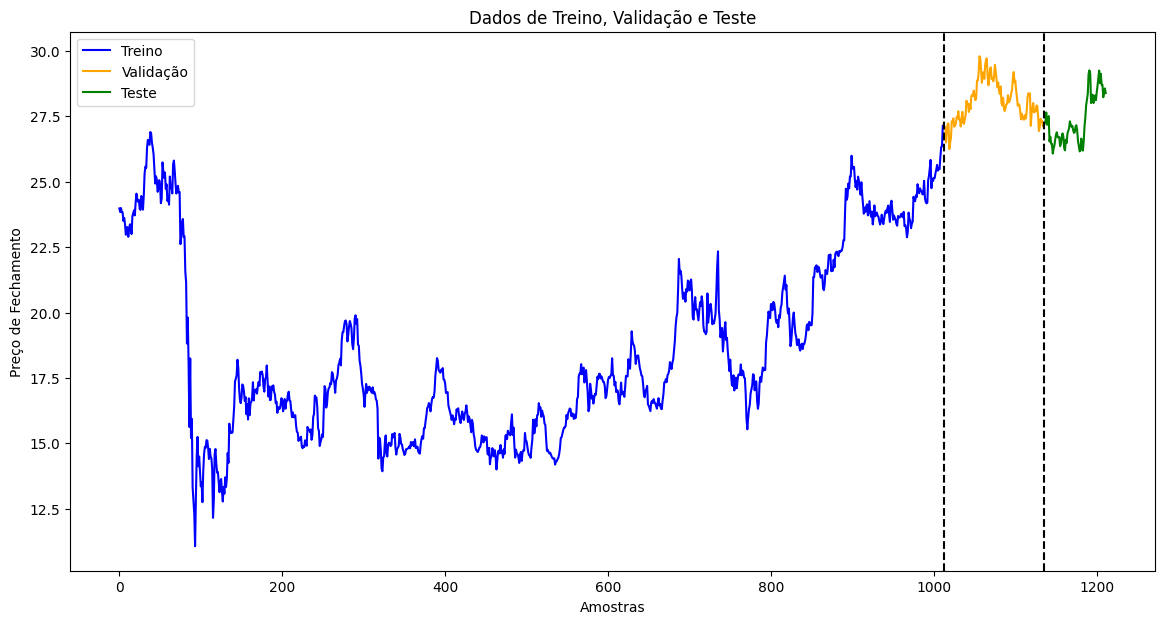

In [ ]:
# Definir o nome da coluna que deseja plotar
column_to_plot = 'Closing Price'

# Combinar os índices para plotagem contínua
train_indices = range(len(train_data))
validation_indices = range(len(train_data), len(train_data) + len(validation_data))
test_indices = range(len(train_data) + len(validation_data), len(train_data) + len(validation_data) + len(test_data))

# Plotar os dados
plt.figure(figsize=(14, 7))

# Dados de treinamento
plt.plot(train_indices, train_data[column_to_plot], label='Treino', color='blue')

# Dados de validação
plt.plot(validation_indices, validation_data[column_to_plot], label='Validação', color='orange')

# Dados de teste
plt.plot(test_indices, test_data[column_to_plot], label='Teste', color='green')

# Adicionar linhas verticais para separar os conjuntos
plt.axvline(x=validation_indices[0], color='black', linestyle='--')
plt.axvline(x=test_indices[0], color='black', linestyle='--')

plt.xlabel('Amostras')
plt.ylabel('Preço de Fechamento')
plt.title('Dados de Treino, Validação e Teste')
plt.legend()
plt.show()


In [ ]:
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=10):
        self.data = data.values
        self.sequence_length = sequence_length
        self.feature_size = data.shape[1] - 1  # Excluindo 'Closing Price'

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        # Sequência de entrada X: features dos primeiros 'sequence_length' dias
        X = self.data[idx:idx + self.sequence_length, :-1]  # Exclui 'Closing Price'

        # Sequência de saída y_history: 'Closing Price' dos primeiros 'sequence_length - 1' dias
        y_history = self.data[idx:idx + self.sequence_length - 1, -1]  # Apenas 'Closing Price'

        # Valor alvo y_target: 'Closing Price' do último dia da sequência
        y_target = self.data[idx + self.sequence_length - 1, -1]  # 'Closing Price' no dia t+9

        return {
            'X': torch.tensor(X, dtype=torch.float32),
            'y_history': torch.tensor(y_history, dtype=torch.float32),
            'y_target': torch.tensor(y_target, dtype=torch.float32)
        }

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando o dispositivo: {device}')

Usando o dispositivo: cuda


In [ ]:
train_dataset = StockDataset(train_data)
validation_dataset = StockDataset(validation_data)
test_dataset = StockDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, time_steps):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.time_steps = time_steps
        self.input_attention = nn.Linear(hidden_size + input_size, 1)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = torch.zeros(1, batch_size, self.hidden_size).to(device)  # Movido para o dispositivo
        encoded_outputs = []

        # x deve ter a forma [batch_size, time_steps, input_size]

        for t in range(self.time_steps):
            # Pega o input no tempo t
            x_t = x[:, t, :].to(device)  # Move x_t para o dispositivo
            x_t = x_t.unsqueeze(1)  # [batch_size, 1, input_size]

            # Repete o hidden state para concatenar com x_t
            hidden_t = hidden.permute(1, 0, 2)  # [batch_size, 1, hidden_size]

            # Combina hidden_t e x_t
            combined = torch.cat((hidden_t, x_t), dim=2)  # [batch_size, 1, hidden_size + input_size]

            # Calcula os pesos de atenção
            attn_weights = torch.softmax(self.input_attention(combined.squeeze(1)), dim=1)  # [batch_size, 1]

            # Aplica os pesos de atenção a x_t
            attended_input = attn_weights * x_t.squeeze(1)  # [batch_size, input_size]
            attended_input = attended_input.unsqueeze(1)  # [batch_size, 1, input_size]

            # Passa pela GRU
            output, hidden = self.gru(attended_input, hidden)
            encoded_outputs.append(hidden)

        encoded_outputs = torch.cat(encoded_outputs, dim=0)
        encoded_outputs = encoded_outputs.permute(1, 0, 2)  # [batch_size, time_steps, hidden_size]
        return encoded_outputs, hidden

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, time_steps):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.time_steps = time_steps
        self.temporal_attention = nn.Linear(hidden_size * 2, 1)
        self.gru = nn.GRU(1, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size + hidden_size, output_size)

    def forward(self, y_history, encoder_outputs):
        batch_size = y_history.size(0)
        hidden = torch.zeros(1, batch_size, self.hidden_size).to(device)  # Movido para o dispositivo

        for t in range(self.time_steps - 1):
            # Atenção temporal
            hidden_expanded = hidden.repeat(self.time_steps, 1, 1).permute(1, 0, 2)  # [batch_size, time_steps, hidden_size]
            combined = torch.cat((hidden_expanded, encoder_outputs), dim=2)  # [batch_size, time_steps, hidden_size * 2]
            attn_weights = torch.softmax(
                self.temporal_attention(combined.view(-1, self.hidden_size * 2)), dim=1
            ).view(batch_size, self.time_steps)  # [batch_size, time_steps]

            # Aplica os pesos de atenção
            context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, hidden_size]
            context = context.squeeze(1)  # [batch_size, hidden_size]

            if t < self.time_steps - 1:
                # Prepara o input para a GRU
                y_input = y_history[:, t].unsqueeze(1).unsqueeze(2).to(device)  # [batch_size, 1, 1]

                # Passa pela GRU
                output, hidden = self.gru(y_input, hidden)

        # Previsão final
        y_pred = self.fc(torch.cat((hidden.squeeze(0), context), dim=1))
        return y_pred


In [ ]:
input_size = train_data.shape[1] - 1  # Número de features (excluindo 'Closing Price')
hidden_size = 64
output_size = 1
time_steps = 10

encoder = Encoder(input_size, hidden_size, time_steps).to(device)
decoder = Decoder(hidden_size, output_size, time_steps).to(device)

criterion = nn.MSELoss()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

In [ ]:
num_epochs = 200

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch in train_loader:
        X = batch['X'].to(device)
        y_history = batch['y_history'].to(device)
        y_target = batch['y_target'].to(device)

        # Certifique-se de que os tensores estão no tipo correto
        X = X.float()
        y_history = y_history.float()
        y_target = y_target.float()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(X)
        decoder_output = decoder(y_history, encoder_outputs)

        loss = criterion(decoder_output.squeeze(), y_target)
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    print(f'Época {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.6f}')

    # Validação
    encoder.eval()
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in validation_loader:
            X = batch['X'].to(device)
            y_history = batch['y_history'].to(device)
            y_target = batch['y_target'].to(device)

            X = X.float()
            y_history = y_history.float()
            y_target = y_target.float()

            encoder_outputs, encoder_hidden = encoder(X)
            decoder_output = decoder(y_history, encoder_outputs)

            loss = criterion(decoder_output.squeeze(), y_target)
            val_loss += loss.item()

        print(f'Validação Loss: {val_loss / len(validation_loader):.6f}')


Época 1/200, Loss: 0.758770


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validação Loss: 0.071974
Época 2/200, Loss: 0.068723
Validação Loss: 0.057587
Época 3/200, Loss: 0.053273
Validação Loss: 0.041589
Época 4/200, Loss: 0.044370
Validação Loss: 0.038893
Época 5/200, Loss: 0.040042
Validação Loss: 0.035704
Época 6/200, Loss: 0.035229
Validação Loss: 0.038940
Época 7/200, Loss: 0.037531
Validação Loss: 0.039047
Época 8/200, Loss: 0.034505
Validação Loss: 0.033162
Época 9/200, Loss: 0.031426
Validação Loss: 0.033365
Época 10/200, Loss: 0.030033
Validação Loss: 0.034642
Época 11/200, Loss: 0.033578
Validação Loss: 0.031183
Época 12/200, Loss: 0.031403
Validação Loss: 0.030813
Época 13/200, Loss: 0.027887
Validação Loss: 0.031762
Época 14/200, Loss: 0.028888
Validação Loss: 0.030125
Época 15/200, Loss: 0.032031
Validação Loss: 0.032240
Época 16/200, Loss: 0.031852
Validação Loss: 0.029864
Época 17/200, Loss: 0.034690
Validação Loss: 0.036080
Época 18/200, Loss: 0.030046
Validação Loss: 0.029279
Época 19/200, Loss: 0.028883
Validação Loss: 0.031062
Época 20/20

In [ ]:
encoder.eval()
decoder.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch in test_loader:
        X = batch['X'].to(device)
        y_history = batch['y_history'].to(device)
        y_target = batch['y_target'].to(device)

        X = X.float()
        y_history = y_history.float()
        y_target = y_target.float()

        encoder_outputs, encoder_hidden = encoder(X)
        decoder_output = decoder(y_history, encoder_outputs)

        predictions.append(decoder_output.item())
        actuals.append(y_target.item())


In [ ]:
mse = criterion(torch.tensor(predictions), torch.tensor(actuals)).item()
print(f'MSE no Conjunto de Teste: {mse:.6f}')

MSE no Conjunto de Teste: 0.010533


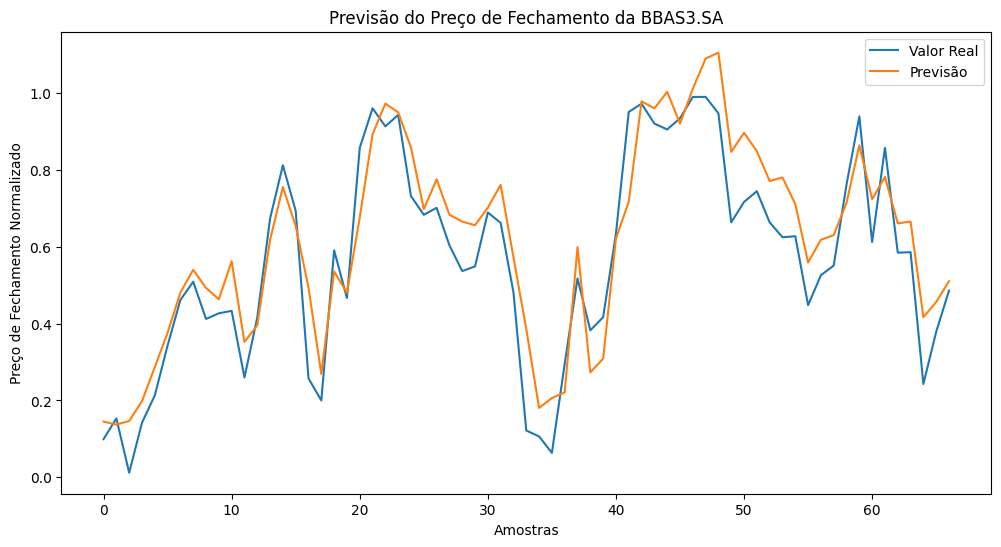

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Valor Real')
plt.plot(predictions, label='Previsão')
plt.legend()
plt.xlabel('Amostras')
plt.ylabel('Preço de Fechamento Normalizado')
plt.title('Previsão do Preço de Fechamento da BBAS3.SA')
plt.show()


In [ ]:
def profitability_performance(y_pred, y_true):
    correct = 0
    for i in range(1, len(y_pred)):
        if (y_pred[i] - y_pred[i - 1]) * (y_true[i] - y_true[i - 1]) > 0:
            correct += 1
    return correct / (len(y_pred) - 1)

pp = profitability_performance(predictions, actuals)
print(f'Profitability Performance (PP): {pp:.2%}')

Profitability Performance (PP): 78.79%
